In [1]:
import torch
import pandas as pd
import numpy as np
import requests
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

# Ustawienie urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/karotka/sem10/cuda/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ładowanie modelu do embeddingów
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)


In [3]:
def get_embeddings(texts: List[str], tokenizer, model):
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encoded_inputs)
    token_embeddings = outputs.last_hidden_state
    embeddings = torch.mean(token_embeddings, dim=1)
    return embeddings.cpu().numpy()


In [4]:
# Wczytaj plik CSV
puzzles_df = pd.read_csv('puzzles_dataset.csv')  # <-- dostosuj ścieżkę jeśli trzeba

puzzles_texts = puzzles_df['puzzle'].tolist()
puzzles_answers = puzzles_df['answer'].tolist()
puzzles_difficulties = puzzles_df['difficulty'].tolist()


In [5]:
# Obliczenie embeddingów dla bazy zagadek
puzzles_embeddings = get_embeddings(puzzles_texts, tokenizer, model)


In [6]:
class ReasoningFewShotAgent:
    def __init__(self, tokenizer, model, db_texts, db_answers, db_embeddings, ollama_model="mistral", ollama_endpoint="http://localhost:11434"):
        self.tokenizer = tokenizer
        self.model = model
        self.db_texts = db_texts
        self.db_answers = db_answers
        self.db_embeddings = db_embeddings
        self.ollama_model = ollama_model
        self.ollama_endpoint = ollama_endpoint

    def get_query_embedding(self, query: str):
        return get_embeddings([query], self.tokenizer, self.model)[0]

    def retrieve_examples(self, query_embedding, top_k=3):
        similarities = cosine_similarity([query_embedding], self.db_embeddings)[0]
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        examples = [(self.db_texts[i], self.db_answers[i]) for i in top_indices]
        return examples

    def build_prompt(self, examples, query):
        prompt = (
            "Jesteś agentem rozwiązującym zagadki logiczne.\n"
            "Twoim zadaniem jest rozwiązać zagadkę krok po kroku.\n\n"
            "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
            "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
            "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
            "Przykłady:\n"
        )
        for i, (ex_question, ex_answer) in enumerate(examples):
            prompt += f"{i+1}. Zagadka: {ex_question}\nOdpowiedź: {ex_answer}\n\n"
        prompt += f"Nowa zagadka:\n{query}\n"
        return prompt


    def query_ollama(self, prompt):
        response = requests.post(
            f"{self.ollama_endpoint}/api/generate",
            json={
                "model": self.ollama_model,
                "prompt": prompt,
                "stream": False
            }
        )

        if response.status_code != 200:
            raise Exception(f"Błąd komunikacji z Ollama: {response.status_code} {response.text}")

        return response.json().get('response', '').strip()

    def solve(self, query: str, top_k=3, verbose: bool = True):
        query_embedding = self.get_query_embedding(query)
        examples = self.retrieve_examples(query_embedding, top_k=top_k)
        prompt = self.build_prompt(examples, query)
        response = self.query_ollama(prompt)

        if verbose:
            print("🧠 Symulacja rozumowania agenta:\n")
            print(response)

        return response


In [7]:
# Inicjalizacja ReasoningFewShotAgenta
agent = ReasoningFewShotAgent(
    tokenizer=tokenizer,
    model=model,
    db_texts=puzzles_texts,
    db_answers=puzzles_answers,
    db_embeddings=puzzles_embeddings,
    ollama_model="mistral"  # lub "mixtral" jeśli chcesz dokładniejszy model
)

# Test na nowej zagadce
query = "Ala ma więcej cukierków niż Ola. Ola ma więcej niż Ela. Kto ma najwięcej cukierków?"
agent.solve(query, top_k=3, verbose=True)


🧠 Symulacja rozumowania agenta:

Odpowiedź: Ala


'Odpowiedź: Ala'

In [65]:
import re
from collections import defaultdict

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip().lower()
    text = text.replace("odpowiedź", "").strip()
    return text

def evaluate_answers(agent, test_queries, test_answers, verbose) -> tuple:
    correct = 0
    for query, answer in zip(test_queries, test_answers):
        answer = normalize_text(answer.strip())
        if verbose:
            print(f'\n\nQuery is: {query}\t Correct answer is: {answer}')
        response = normalize_text(agent.solve(query, top_k=3, verbose = verbose).strip())
        if response == answer:
            print("Answer was correct :)")
            correct += 1
        else:
            print(f'Response:[{response}] vs answer[{answer}]')
    return correct, len(test_queries) - correct

def evaluate_agent_by_category(agent, puzzles_df, verbose = True):
    difficulties = puzzles_df['difficulty'].unique()
    
    accuracy_score = defaultdict(lambda: (int, int))
    for difficulty in difficulties:
        print(f"Processing difficulty: {difficulty}")
        category_rows = puzzles_df[puzzles_df['difficulty'] == difficulty]
        
        test_queries = category_rows["puzzle"].tolist()
        test_answers = category_rows["answer"].tolist()
        accuracy_score[difficulty] = evaluate_answers(agent, test_queries, test_answers, verbose)
        
    return accuracy_score
    
accuracies = evaluate_agent_by_category(agent, puzzles_df)

Processing difficulty: easy


Query is: Anna ma więcej jabłek niż Basia. Basia ma więcej niż Celina. Kto ma najwięcej jabłek?	 Correct answer is: anna
🧠 Symulacja rozumowania agenta:

Odpowiedź: Anna
Answer was correct :)


Query is: Tomek jest młodszy od Michała, ale starszy od Piotra. Kto jest najstarszy?	 Correct answer is: michał
🧠 Symulacja rozumowania agenta:

Odpowiedź: Michał
Answer was correct :)


Query is: Która liczba jest większa: 35 czy 53?	 Correct answer is: 53
🧠 Symulacja rozumowania agenta:

Odpowiedź: 53
Answer was correct :)


Query is: Pies waży więcej niż kot, ale mniej niż koń. Które zwierzę jest najcięższe?	 Correct answer is: koń
🧠 Symulacja rozumowania agenta:

Odpowiedź: koń
Answer was correct :)


Query is: Jeśli dzisiaj jest wtorek, jaki dzień będzie za trzy dni?	 Correct answer is: piątek
🧠 Symulacja rozumowania agenta:

Odpowiedź: piątek
Answer was correct :)


Query is: Mama Adama ma trzech synów: Kwiatek, Motylek i...?	 Correct answer is: adam
🧠 Symulac

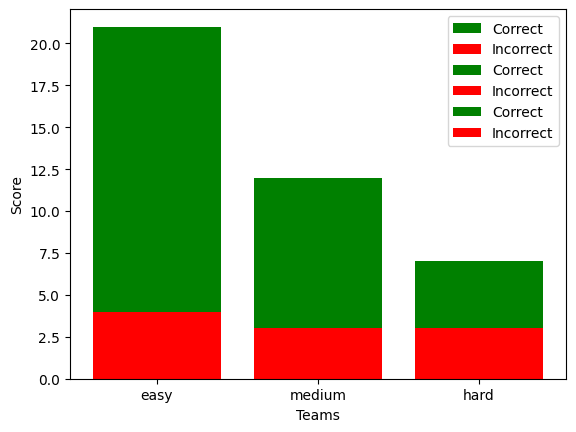

In [66]:
import matplotlib.pyplot as plt

def plot_accuracies(acc_dict: dict):
    i = 1
    for diff in acc_dict.keys():
        plt.bar(diff, acc_dict[diff][0], width = 0.8, color='g', label='Correct')
        plt.bar(diff, acc_dict[diff][1], width = 0.8, color='r', label='Incorrect')
        
    plt.xlabel("Teams")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
plot_accuracies(accuracies)